<a href="https://colab.research.google.com/github/Ushnish-Sengupta/Rijke/blob/master/Rijke.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%tensorflow_version 1.x
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [0]:
# NN class
class NN():
  def __init__(self, x_dim, y_dim, hidden_size, init_stddev_1_w, init_stddev_1_b, init_stddev_2_w, init_stddev_2_b, init_stddev_3_w, learning_rate):
    # setting up as for a usual NN
    self.x_dim = x_dim
    self.y_dim = y_dim
    self.hidden_size = hidden_size
    self.learning_rate = learning_rate
    
    # set up NN
    self.inputs = tf.placeholder(tf.float32, [None, x_dim], name='inputs')
    self.y_target = tf.placeholder(tf.float32, [None, y_dim], name='target')
    
    self.layer_1_w = tf.layers.Dense(hidden_size, activation=tf.nn.selu, # try using tf.nn.relu, tf.erf, tf.nn.tanh etc.
                                     kernel_initializer=tf.random_normal_initializer(mean=0.,stddev=init_stddev_1_w),
                                     bias_initializer=tf.random_normal_initializer(mean=0.,stddev=init_stddev_1_b))
    self.layer_1 = self.layer_1_w.apply(self.inputs)
    self.layer_2_w = tf.layers.Dense(hidden_size, activation=tf.nn.selu, # try using tf.nn.relu, tf.erf, tf.nn.tanh etc.
                                     kernel_initializer=tf.random_normal_initializer(mean=0.,stddev=init_stddev_2_w),
                                     bias_initializer=tf.random_normal_initializer(mean=0.,stddev=init_stddev_2_b))
    self.layer_2 = self.layer_2_w.apply(self.layer_1)
    self.output_w = tf.layers.Dense(y_dim, activation=None, use_bias=False,
                                    kernel_initializer=tf.random_normal_initializer(mean=0.,stddev=init_stddev_3_w))
    self.output = self.output_w.apply(self.layer_2)
    
    # set up loss and optimiser - we'll modify this later with anchoring regularisation
    self.opt_method = tf.train.AdamOptimizer(self.learning_rate)
    err_sq_1 = tf.square(self.y_target[:,0] - self.output[:,0])
    err_sq_2 = tf.square(self.y_target[:,1] - self.output[:,1])
    num_data_inv = tf.cast(tf.divide(1, tf.shape(self.inputs)[0]), dtype=tf.float32)
    self.mse_ = num_data_inv * tf.reduce_sum(tf.divide(err_sq_1, noise_sq_1) + tf.divide(err_sq_2, noise_sq_2))
    self.loss_ = num_data_inv * tf.reduce_sum(tf.divide(err_sq_1, noise_sq_1) + tf.divide(err_sq_2, noise_sq_2))
    self.optimizer = self.opt_method.minimize(self.loss_)
    return
    
    
  def get_weights(self, sess):
    '''method to return current params'''
    ops = [self.layer_1_w.kernel, self.layer_1_w.bias, self.layer_2_w.kernel, self.layer_2_w.bias, self.output_w.kernel]
    w1, b1, w2, b2, w3 = sess.run(ops)
    return w1, b1, w2, b2, w3
    
  def anchor(self, sess, lambda_anchor):
    '''regularise around initialised parameters'''
    w1, b1, w2, b2, w3 = self.get_weights(sess)
    
    # get initial params
    self.w1_init, self.b1_init, self.w2_init, self.b2_init, self.w3_init = w1, b1, w2, b2, w3
    loss_anchor = lambda_anchor[0]*tf.reduce_sum(tf.square(self.w1_init - self.layer_1_w.kernel))
    loss_anchor += lambda_anchor[1]*tf.reduce_sum(tf.square(self.b1_init - self.layer_1_w.bias))
    loss_anchor += lambda_anchor[2]*tf.reduce_sum(tf.square(self.w2_init - self.layer_2_w.bias))
    loss_anchor += lambda_anchor[3]*tf.reduce_sum(tf.square(self.b2_init - self.layer_2_w.bias))
    loss_anchor += lambda_anchor[4]*tf.reduce_sum(tf.square(self.w3_init - self.output_w.kernel))
    
    # combine with original loss
    self.loss_ = self.loss_ + tf.cast(1/tf.shape(self.inputs)[0], dtype=tf.float32) * loss_anchor
    self.optimizer = self.opt_method.minimize(self.loss_)
    return
    
  def predict(self, x, sess):
    '''predict method'''
    feed = {self.inputs: x}
    y_pred = sess.run(self.output, feed_dict=feed)
    return y_pred

In [0]:
from scipy.io import loadmat
import numpy as np
X_train= loadmat('datachunk_ee.mat')['X_train']
X_test = loadmat('datachunk_ee.mat')['X_test']
y_train = np.squeeze(loadmat('datachunk_ee.mat')['Y_train'])
y_test = np.squeeze(loadmat('datachunk_ee.mat')['Y_test'])

In [0]:
#Do minmax scaling
min_x = X_train.min(0)
max_x = X_train.max(0)
X_train = 2*(X_train - min_x)/(max_x - min_x) - 1
X_test = 2*(X_test - min_x)/(max_x - min_x) - 1
#Do minmax scaling
min_y = y_train.min(0)
max_y = y_train.max(0)
y_train = 2*(y_train - min_y)/(max_y - min_y) - 1
y_test = 2*(y_test - min_y)/(max_y - min_y) - 1
#columns of x and y are [-1,1] now

In [0]:
# hyperparameters
n = X_train.shape[0]
print(n)
x_dim = X_train.shape[1]
print(x_dim)
y_dim = y_train.shape[1]
print(y_dim)

noise_sq_1 = (0.15/((max_y[0] - min_y[0])/2))**2
noise_sq_2 = (0.15/((max_y[1] - min_y[1])/2))**2
n_ensembles = 25
hidden_size = 30
init_stddev_1_w =  np.sqrt(1.0/x_dim) #tune 10.0
init_stddev_1_b = init_stddev_1_w # set these equal
init_stddev_2_w =  1.0/np.sqrt(hidden_size) #tune 1.0
init_stddev_2_b = init_stddev_2_w # set these equal
init_stddev_3_w = 1.0/np.sqrt(hidden_size) #tune 1.0
lambda_anchor = 1.0/(np.array([init_stddev_1_w,init_stddev_1_b,init_stddev_2_w,init_stddev_2_b,init_stddev_3_w])**2)

n_epochs = 512
batch_size = 32
learning_rate = 0.00001

13421
28
2


In [0]:
NNs=[]
y_prior=[]
tf.reset_default_graph()
sess = tf.Session()

# loop to initialise all ensemble members, get priors
for ens in range(0,n_ensembles):
    NNs.append(NN(x_dim, y_dim, hidden_size, init_stddev_1_w, init_stddev_1_b, init_stddev_2_w, init_stddev_2_b, init_stddev_3_w,
                  learning_rate))
    
    # initialise only uninitialized variables - stops overwriting ensembles already created
    global_vars = tf.global_variables()
    is_not_initialized   = sess.run([tf.is_variable_initialized(var) for var in global_vars])
    not_initialized_vars = [v for (v, f) in zip(global_vars, is_not_initialized) if not f]
    if len(not_initialized_vars):
        sess.run(tf.variables_initializer(not_initialized_vars))
    
    # do regularisation now that we've created initialisations
    NNs[ens].anchor(sess, lambda_anchor)

Instructions for updating:
Please use `layer.__call__` method instead.


In [0]:
def fn_predict_ensemble(NNs,X_train):
  y_pred=[]
  for ens in range(0,n_ensembles):
    y_pred.append(NNs[ens].predict(X_train, sess))
  y_preds_train = np.array(y_pred)
  y_preds_mu_train = np.mean(y_preds_train,axis=0)
  y_preds_std_train_epi = np.std(y_preds_train,axis=0)
  #y_preds_std_train = np.sqrt(np.square(y_preds_std_train_epi) + np.square(data_noise)) #add measurement noise
  return y_preds_train, y_preds_mu_train, y_preds_std_train_epi

In [0]:
y_preds_train, y_preds_mu_train,  y_preds_std_train_epi = fn_predict_ensemble(NNs,X_train)
y_preds_test, y_preds_mu_test,  y_preds_std_test_epi = fn_predict_ensemble(NNs,X_test)

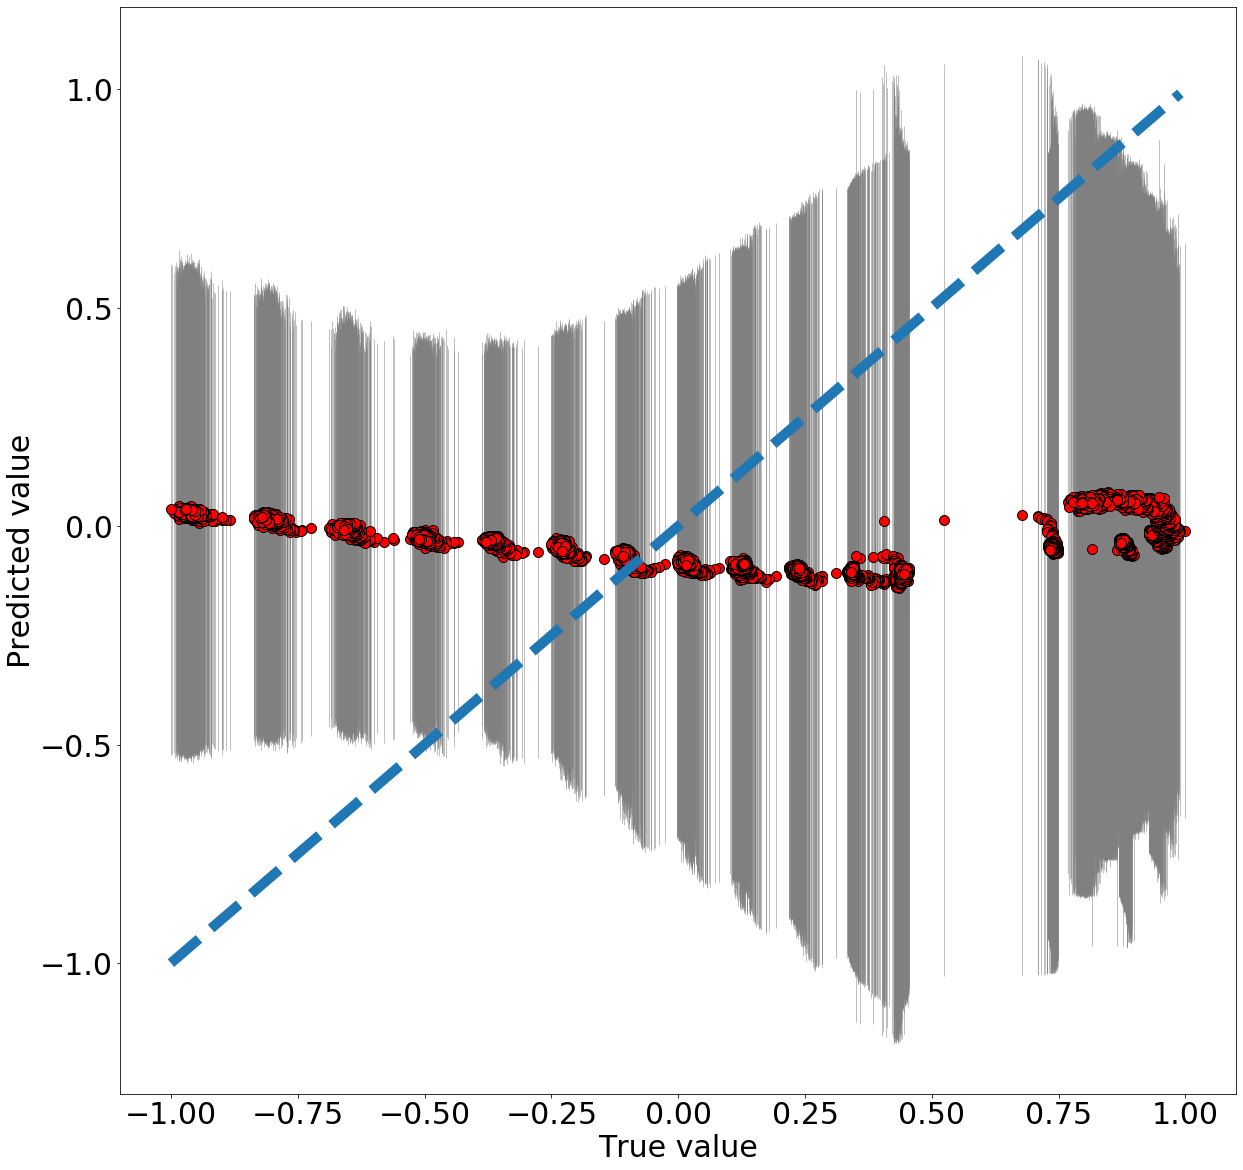

In [0]:
# plot prior predictive distribution
plt.rcParams.update({'font.size': 30})
plt.figure(figsize=(20,20))
plt.errorbar(y_train[:,0], y_preds_mu_train[:,0], yerr=(y_preds_std_train_epi[:,0]*1),linewidth = 0.5, color = 'gray', ms=10,mfc='red',mec='black', fmt='o')
plt.plot(np.arange(np.min(y_train[:,0]), np.max(y_train[:,0]), 0.01), np.arange(np.min(y_train[:,0]), np.max(y_train[:,0]), 0.01), linewidth = 10, linestyle = 'dashed',zorder = 100)
plt.xlabel('True value')
plt.ylabel('Predicted value')
plt.show()

In [0]:
# do training loop
for ens in range(0,n_ensembles):
  print('\nNN:',ens)
  ep_ = 0
  while ep_ < n_epochs:
    ep_ += 1
    for j in range(int(n/batch_size)): #minibatch training loop
      feed_b = {}
      feed_b[NNs[ens].inputs] = X_train[j*batch_size:(j+1)*batch_size, :]
      feed_b[NNs[ens].y_target] = y_train[j*batch_size:(j+1)*batch_size, :]
      blank = sess.run(NNs[ens].optimizer, feed_dict=feed_b)
    if (ep_ % 5) == 0:
      feed_b = {}
      feed_b[NNs[ens].inputs] = X_train
      feed_b[NNs[ens].y_target] = y_train
      loss_mse = sess.run(NNs[ens].mse_, feed_dict=feed_b)
      loss_anch = sess.run(NNs[ens].loss_, feed_dict=feed_b)
      print('epoch:', ep_, ', mse_', np.round(loss_mse,3), ', loss_anch', np.round(loss_anch,3))
      # we're minimising the anchored loss, but it's useful to keep an eye on mse too


NN: 0
epoch: 5 , mse_ 98.917 , loss_anch 99.035
epoch: 10 , mse_ 38.978 , loss_anch 39.095
epoch: 15 , mse_ 18.308 , loss_anch 18.423
epoch: 20 , mse_ 10.767 , loss_anch 10.879
epoch: 25 , mse_ 7.581 , loss_anch 7.69
epoch: 30 , mse_ 5.678 , loss_anch 5.783
epoch: 35 , mse_ 4.295 , loss_anch 4.396
epoch: 40 , mse_ 3.345 , loss_anch 3.442
epoch: 45 , mse_ 2.731 , loss_anch 2.824
epoch: 50 , mse_ 2.246 , loss_anch 2.336
epoch: 55 , mse_ 1.933 , loss_anch 2.019
epoch: 60 , mse_ 1.716 , loss_anch 1.798
epoch: 65 , mse_ 1.543 , loss_anch 1.623
epoch: 70 , mse_ 1.388 , loss_anch 1.466
epoch: 75 , mse_ 1.251 , loss_anch 1.326
epoch: 80 , mse_ 1.137 , loss_anch 1.211
epoch: 85 , mse_ 1.058 , loss_anch 1.13
epoch: 90 , mse_ 0.987 , loss_anch 1.058
epoch: 95 , mse_ 0.92 , loss_anch 0.989
epoch: 100 , mse_ 0.857 , loss_anch 0.926
epoch: 105 , mse_ 0.8 , loss_anch 0.867
epoch: 110 , mse_ 0.75 , loss_anch 0.816
epoch: 115 , mse_ 0.709 , loss_anch 0.776
epoch: 120 , mse_ 0.681 , loss_anch 0.747
epo

In [0]:
y_preds_train, y_preds_mu_train, y_preds_std_train_epi = fn_predict_ensemble(NNs,X_train)
y_preds_test, y_preds_mu_test, y_preds_std_test_epi = fn_predict_ensemble(NNs,X_test)

In [0]:
y_test[:,0] = (y_test[:,0] + 1)*((max_y[0] - min_y[0])/2) + min_y[0]
y_train[:,0] = (y_train[:,0] + 1)*((max_y[0] - min_y[0])/2) + min_y[0]
y_preds_mu_train[:,0] = (y_preds_mu_train[:,0] + 1)*((max_y[0] - min_y[0])/2) + min_y[0]
y_preds_mu_test[:,0] = (y_preds_mu_test[:,0] + 1)*((max_y[0] - min_y[0])/2) + min_y[0]
y_preds_std_train_epi[:,0] = y_preds_std_train_epi[:,0]*((max_y[0] - min_y[0])/2)
y_preds_std_test_epi[:,0] = y_preds_std_test_epi[:,0]*((max_y[0] - min_y[0])/2)

In [0]:
print(np.sqrt(np.mean(np.square(y_preds_mu_test[:,0] - y_test[:,0]))))
print(np.sqrt(np.mean(np.square(y_preds_mu_train[:,0] - y_train[:,0]))))

2.9408169338010715
0.029764908842939603


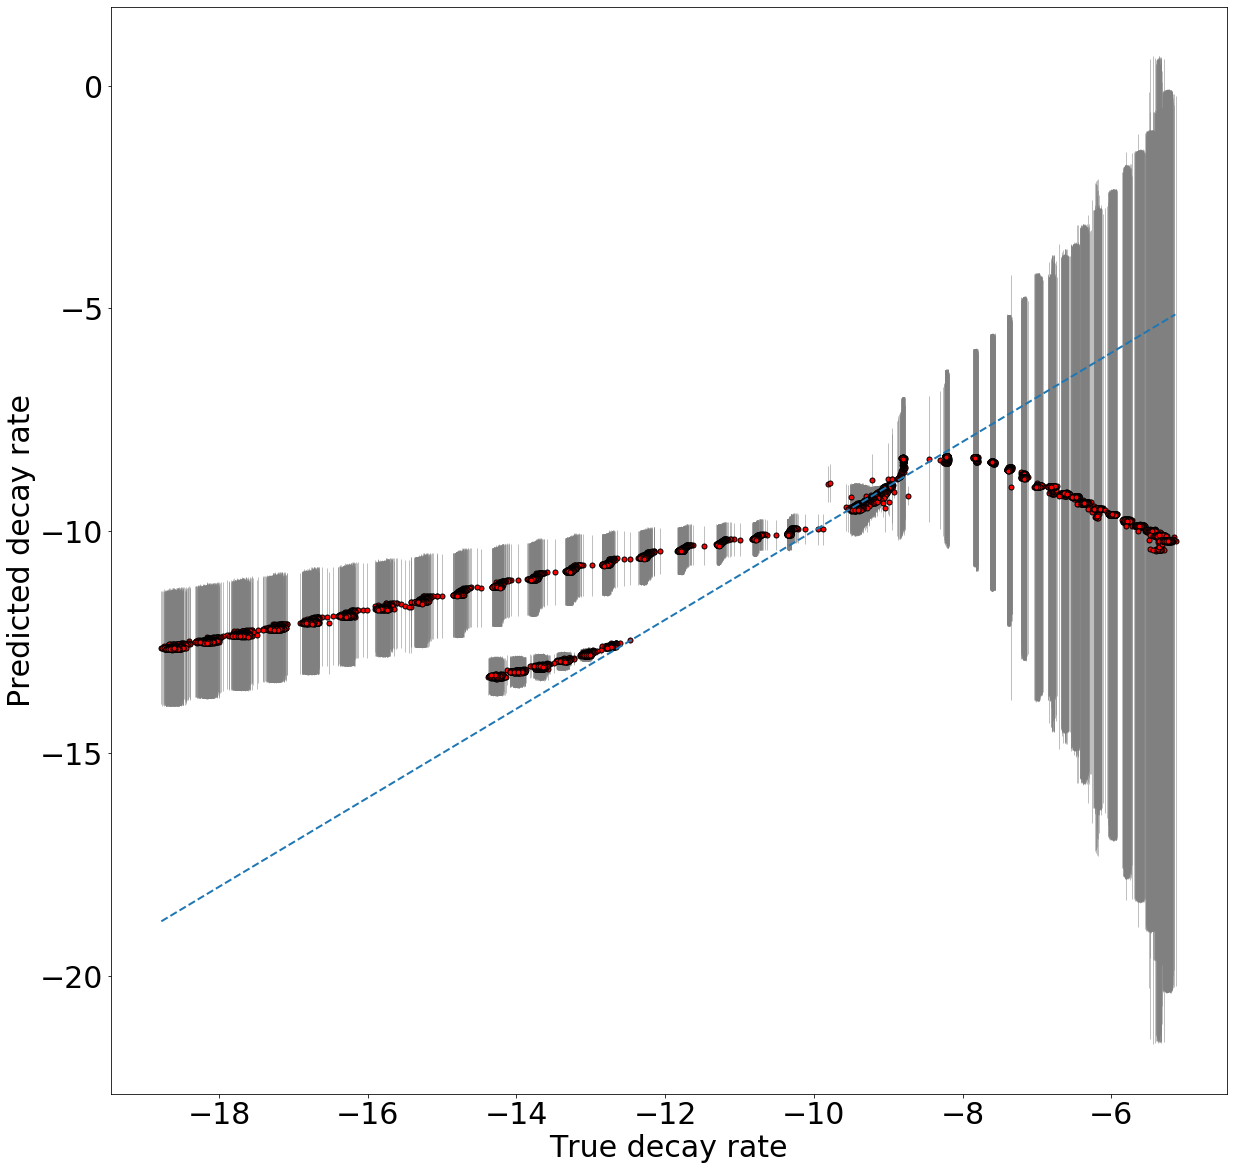

In [0]:
# plot predictive distribution
plt.rcParams.update({'font.size': 30})
plt.figure(figsize=(20,20))
plt.errorbar(y_test[:,0], y_preds_mu_test[:,0], yerr=(y_preds_std_test_epi[:,0]*1),linewidth = 0.5, color = 'gray', ms=5,mfc='red',mec='black', fmt='o')
plt.plot(np.arange(np.min(y_test[:,0]), np.max(y_test[:,0]), 0.01), np.arange(np.min(y_test[:,0]), np.max(y_test[:,0]), 0.01), linewidth = 2, linestyle = 'dashed',zorder = 100)
plt.xlabel('True decay rate')
plt.ylabel('Predicted decay rate')
plt.draw()
plt.savefig('Decayrate_test.png', format='png')

In [0]:
y_test[:,1] = (y_test[:,1] + 1)*((max_y[1] - min_y[1])/2) + min_y[1]
y_train[:,1] = (y_train[:,1] + 1)*((max_y[1] - min_y[1])/2) + min_y[1]
y_preds_mu_train[:,1] = (y_preds_mu_train[:,1] + 1)*((max_y[1] - min_y[1])/2) + min_y[1]
y_preds_mu_test[:,1] = (y_preds_mu_test[:,1] + 1)*((max_y[1] - min_y[1])/2) + min_y[1]
y_preds_std_train_epi[:,1] = y_preds_std_train_epi[:,1]*((max_y[1] - min_y[1])/2)
y_preds_std_test_epi[:,1] = y_preds_std_test_epi[:,1]*((max_y[1] - min_y[1])/2)

In [0]:
print('Train RMSE: {}'.format(np.sqrt(np.mean(np.square(y_preds_mu_train[:,1] - y_train[:,1])))))
print('Test RMSE: {}'.format(np.sqrt(np.mean(np.square(y_preds_mu_test[:,1] - y_test[:,1])))))

Train RMSE: 0.05813000814732067
Test RMSE: 1.5846228192208305


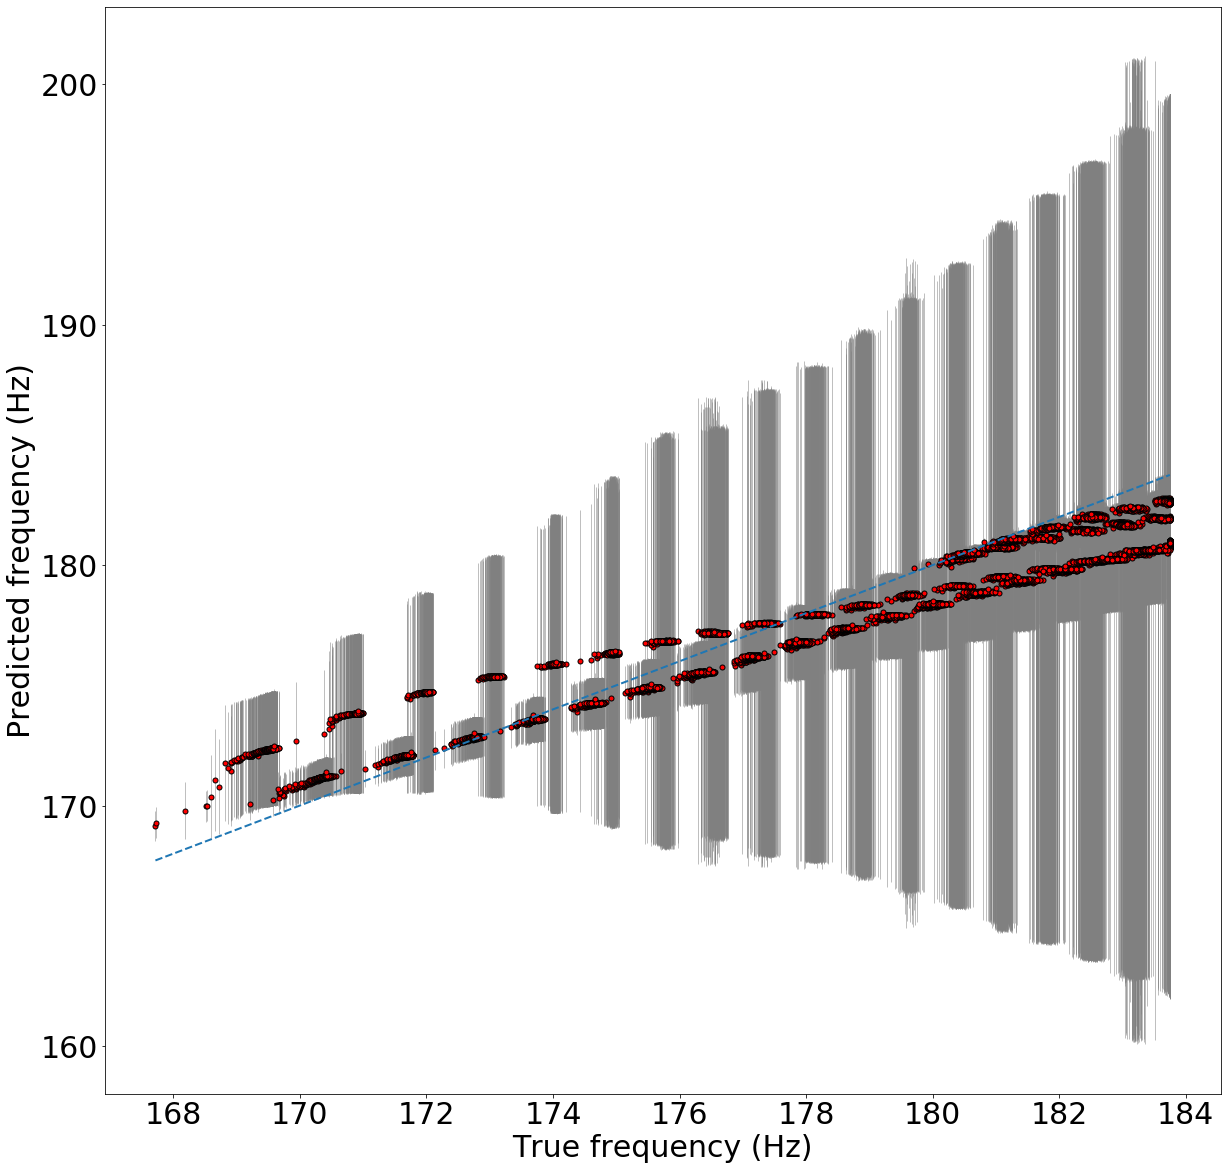

In [0]:
# plot predictive distribution
plt.rcParams.update({'font.size': 30})
plt.figure(figsize=(20,20))
plt.errorbar(y_test[:,1], y_preds_mu_test[:,1], yerr=(y_preds_std_test_epi[:,1]*1),linewidth = 0.5, color = 'gray', ms=5,mfc='red',mec='black', fmt='o')
plt.plot(np.arange(np.min(y_test[:,1]), np.max(y_test[:,1]), 0.01), np.arange(np.min(y_test[:,1]), np.max(y_test[:,1]), 0.01), linewidth = 2, linestyle = 'dashed',zorder = 100)
plt.xlabel('True frequency (Hz)')
plt.ylabel('Predicted frequency (Hz)')
plt.draw()
plt.savefig('Freq_test.png', format='png')